In [1]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from captum.robust import FGSM, MinParamPerturbation

c:\Projects\AdvAttack\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def viewBatch(model, batch, preprocessor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    outputs = model(preprocessor(batch).to(device))
    val, idx = torch.max(outputs.logits, dim=1)
    idx = idx.tolist()

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))  # Create a 4x4 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

    for i, (img, id) in enumerate(zip(batch[:16], idx[:16])):
        img = img.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change C, H, W to H, W, C
        img = np.clip(img, 0, 1)  # Ensure pixel values are valid for display
        axes[i].imshow(img)
        labels = model.config.id2label[id]
        axes[i].set_title(f'Classification: {labels.split(",")[0]}')  # Set the title to the label of the image
        axes[i].axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()  # Adjust layout to make room for titles and ensure plots don't overlap
    plt.show()

In [3]:
def viewTensor(tensor):
    img = tensor.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change C, H, W to H, W, C
    img = np.clip(img, 0, 1)  # Ensure pixel values are valid for display
    plt.imshow(img)
    plt.show()

# Load in model, processors and data

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model.eval()
torch.no_grad()

c:\Projects\AdvAttack\.conda\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Strip preprocessing except resize
processor.do_normalize = False
# Implement separate normalization and denormalization functions - and whichever other reversing operations are needed
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
denormalize = transforms.Lambda(lambda x: x * 0.5 + 0.5)


In [6]:
def process_image(image):
    return processor(image, return_tensors="pt").pixel_values.squeeze(0)

dataIN = datasets.ImageFolder('./imagenette', transform=transforms.Lambda(process_image))
# Note, DataLoader breaks with num_workers > 0
dataLoader = torch.utils.data.DataLoader(dataIN,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=0)

# Large Scale Adversarial Generation

In [7]:
def pred(inputs, model, preprocess=True):
  # preprocess the image
  if preprocess:
    inputs = normalize(inputs)

  # If input is not batched, batch it
  if len(inputs.shape) < 4:
    inputs = inputs.unsqueeze(0)

  outputs = model(inputs.to(device))
  logits = outputs.logits
  val, idx = torch.max(logits, dim=1)
  return idx

In [8]:
def fgsmAttack(inputs, model, true_label, epsilon=0.1):
  # Wrapper of the model that outputs logits - needed for FGSM.perturb
  forward_func = lambda *args, **kwargs: model(*args, **kwargs).logits
  fgsm = FGSM(forward_func, lower_bound=-1, upper_bound=1)
  return fgsm.perturb(inputs, epsilon=epsilon, target=true_label)

In [9]:
adversarialBatch = None
inputs = None
for inputs, labels in dataLoader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    labels = pred(inputs, model)
    adversarialBatch = fgsmAttack(inputs, model, labels, epsilon = 0.1)
    break

c:\Projects\AdvAttack\.conda\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


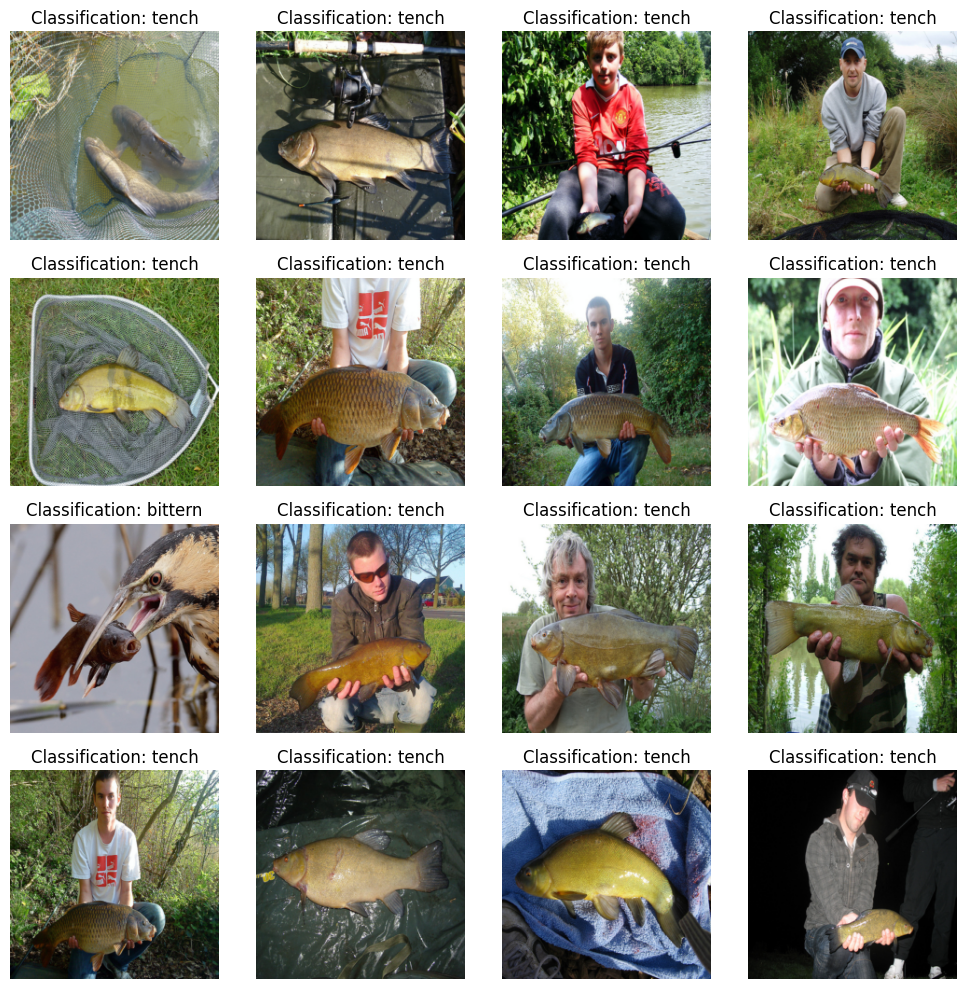

In [10]:
viewBatch(model, inputs, normalize)

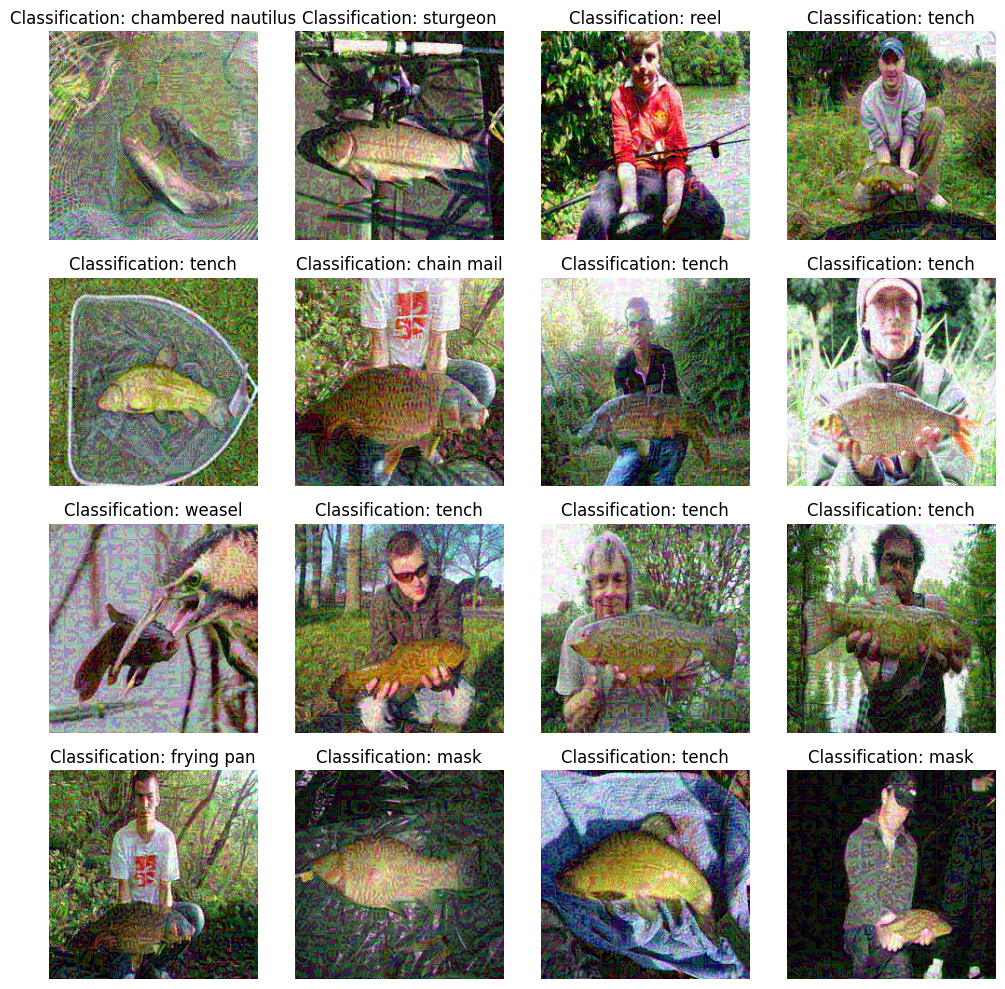

In [11]:
viewBatch(model, adversarialBatch, normalize)

# Adversarial Dataset Builder

In [12]:
import os
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

path_adversarial_dataset = "./data_adv"
os.makedirs(path_adversarial_dataset, exist_ok=True)

In [13]:
def calcImageDistanceMetrics(im1, im2):
    # L-infinity
    linf = torch.norm(im1 - im2, p=float('inf')).item()
    # SSIM and MSE
    im1 = im1.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    im2 = im2.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    mse = mean_squared_error(im1, im2)
    ssim_val = ssim(im1, im2, data_range=(im2.max() - im2.min()), multichannel=True, channel_axis=2)
    return mse, ssim_val, linf

In [14]:
# Saving as Image and Re-loading causes small loss +-0.001, but that is enough to cause the attack to fail
# As such, we save the tensors and load them as a dataset.

def saveImageTensor(tensor, path, label, fname):
    # Ensure directory exists
    dir = f"{path}/{label.item()}"
    os.makedirs(dir, exist_ok=True)
    torch.save(tensor, f"{dir}/{fname}.pt")

MinParamPertubation only works with batchsize one (to find individual minimumpertubations, rather than one for the batch granualarity):
https://captum.ai/api/_modules/captum/robust/_core/metrics/min_param_perturbation.html#MinParamPerturbation.evaluate

In [15]:
labels = "tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute"
labels = labels.split(", ")

In [16]:
dataVal = datasets.ImageFolder('./imagenette/imagenette2/val', transform=transforms.Lambda(process_image))

In [17]:
# Construct dict to translate from imagenette labels to ImageNet labels
netteToImageNetConv = {}
for i, newlabel in enumerate(labels):
    for key, val in model.config.label2id.items():
        # Check which entry in labels is contained in the key
        index = key.find(newlabel)
        if index != -1:
            netteToImageNetConv[i] = val

In [18]:
dataLoader = torch.utils.data.DataLoader(dataVal,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=0)

# Define preproc function to clip tensors to valid range for image
#preproc_fn = lambda x: torch.clamp(x, 0, 1)

min_pert = MinParamPerturbation(
                                forward_func = lambda *args, **kwargs: model(*args, **kwargs).logits,
                                attack = fgsmAttack,
                                arg_name = 'epsilon',
                                mode = "binary",
                                arg_min = 0.001,
                                arg_max = 0.7,
                                arg_step = 0.001,
                                preproc_fn = normalize,
                                apply_before_preproc=True
                               )

alt_im, min_eps, inputs = None, None, None

log = []

for i, (input, label) in enumerate(dataLoader):
    input = input.to(device)
    # Convert label item to ImageNet label
    label = torch.tensor([netteToImageNetConv[label.item()]]).to(device)
    label = label.to(device)

    prediction = pred(input, model)

    if prediction == label:
        # We only care for adversarial examples in the case when the model could correctly predict otherwise
        attack_kwargs={'model':model,'true_label':label}

        alt_im, min_eps = min_pert.evaluate(input, attack_kwargs=attack_kwargs, target=label)

        altpred = pred(alt_im, model)
        print(f"adv_{i} is a {model.config.id2label[label.item()]} but classifies as {model.config.id2label[altpred.item()]} with epsilon {min_eps}")

        mse, ssim_val, linf = calcImageDistanceMetrics(input, alt_im)
        log.append({"index": i, "label": label.item(), "prediction": altpred.item(), "epsilon": min_eps, "mse": mse, "ssim": ssim_val, "linf": linf})

        # Save the adversarial example to new dataset
        saveImageTensor(alt_im, path_adversarial_dataset, label, f"adv_{i}")
    else:
        print(f"Incorrect classification, label: {label}, prediction: {prediction}, skipping...")


c:\Projects\AdvAttack\.conda\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


adv_0 is a tench, Tinca tinca but classifies as cowboy boot with epsilon 0.021
adv_1 is a tench, Tinca tinca but classifies as ski mask with epsilon 0.09500000000000001
adv_2 is a tench, Tinca tinca but classifies as sleeping bag with epsilon 0.033
adv_3 is a tench, Tinca tinca but classifies as gong, tam-tam with epsilon 0.1
adv_4 is a tench, Tinca tinca but classifies as coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch with epsilon 0.003
adv_5 is a tench, Tinca tinca but classifies as hamper with epsilon 0.006
adv_6 is a tench, Tinca tinca but classifies as barracouta, snoek with epsilon 0.08600000000000001
adv_7 is a tench, Tinca tinca but classifies as reel with epsilon 0.052000000000000005
adv_8 is a tench, Tinca tinca but classifies as barrow, garden cart, lawn cart, wheelbarrow with epsilon 0.125
adv_9 is a tench, Tinca tinca but classifies as polecat, fitch, foulmart, foumart, Mustela putorius with epsilon 0.006
adv_10 is a tench, Tinca tinca but classif

In [19]:
# pickle the log
import pickle
with open("data_adv/log.pkl", "wb") as f:
    pickle.dump(log, f)

# Load and Verify Attack

In [22]:
# Load tensor dataset from saved files
loader = lambda x: torch.load(x).squeeze(0)
dataAdv = datasets.DatasetFolder('./data_adv', loader=loader, extensions=('.pt',))

dataLoader = torch.utils.data.DataLoader(dataAdv,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=0)



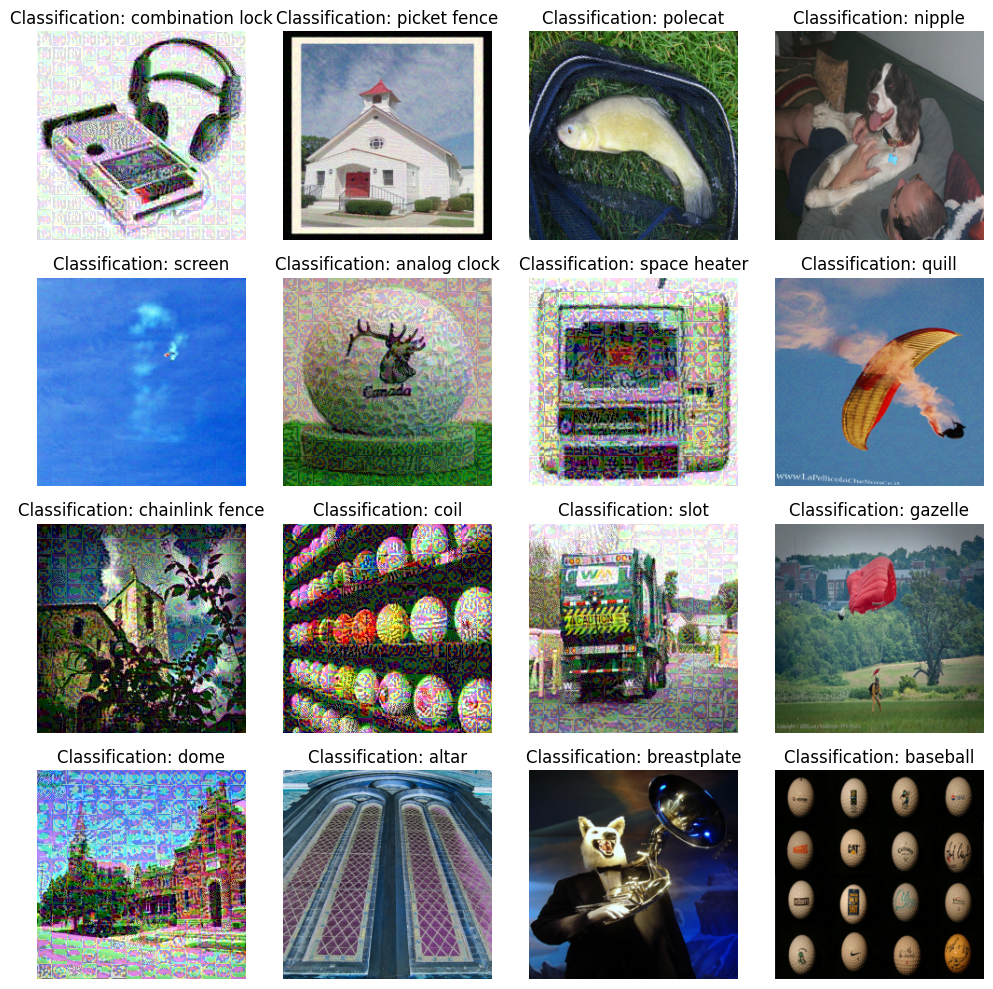

cassette player
church, church building
tench, Tinca tinca
English springer, English springer spaniel
parachute, chute
golf ball
cassette player
parachute, chute
church, church building
golf ball
garbage truck, dustcart
parachute, chute
church, church building
church, church building
French horn, horn
golf ball


In [29]:
for inputs, labels in dataLoader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    viewBatch(model, inputs, normalize)
    # Print the true labels:
    reallabels = [model.config.id2label[netteToImageNetConv[label.item()]] for label in labels]
    for label in reallabels:
        print(label)
    break

# Robustness Analysis

In [31]:
list_ssim = [entry["ssim"] for entry in log]
list_mse = [entry["mse"] for entry in log]
list_linf = [entry["linf"] for entry in log]
list_eps = [entry["epsilon"] for entry in log]

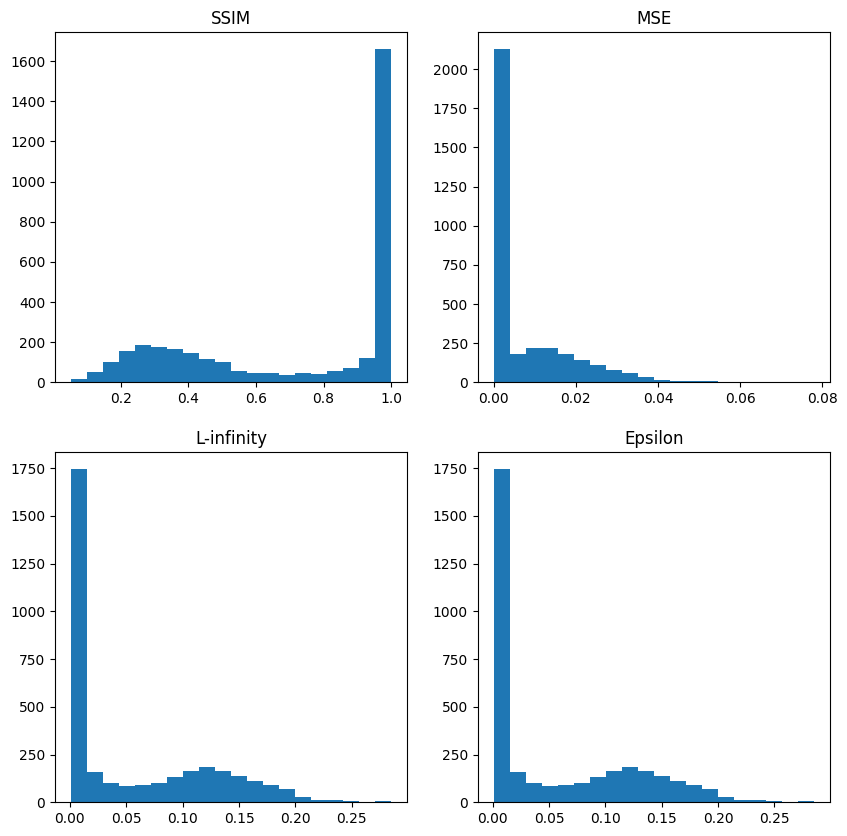

In [36]:
# Plot distribution of SSIM, MSE, L-infinity and epsilon side by side
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(list_ssim, bins=20)
axs[0, 0].set_title("SSIM")
axs[0, 1].hist(list_mse, bins=20)
axs[0, 1].set_title("MSE")
axs[1, 0].hist(list_linf, bins=20)
axs[1, 0].set_title("L-infinity")
axs[1, 1].hist(list_eps, bins=20)
axs[1, 1].set_title("Epsilon")
plt.show()

In [37]:
# Means of the metrics
print(f"Mean SSIM: {np.mean(list_ssim)}")
print(f"Mean MSE: {np.mean(list_mse)}")
print(f"Mean L-infinity: {np.mean(list_linf)}")
print(f"Mean Epsilon: {np.mean(list_eps)}")

Mean SSIM: 0.7185004353523254
Mean MSE: 0.006955285252889921
Mean L-infinity: 0.05629957522239629
Mean Epsilon: 0.05629955947136565


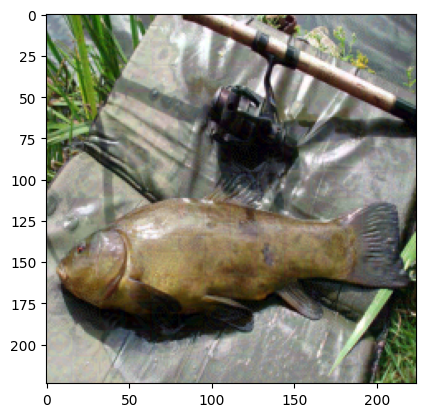

In [49]:
viewTensor(dataAdv[0][0])

In [50]:
log[0]

{'index': 0,
 'label': 0,
 'prediction': 514,
 'epsilon': 0.021,
 'mse': 0.00043903102991715696,
 'ssim': 0.9419575,
 'linf': 0.021000027656555176}

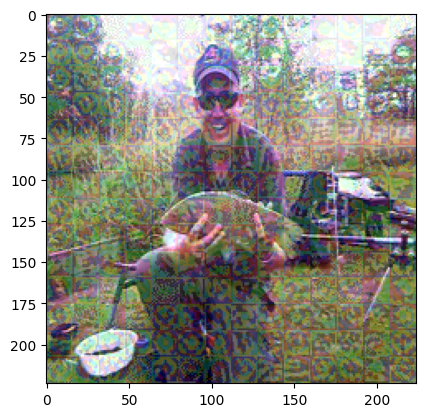

In [47]:
viewTensor(dataAdv[1][0])

In [48]:
log[1]

{'index': 1,
 'label': 0,
 'prediction': 796,
 'epsilon': 0.09500000000000001,
 'mse': 0.008624687142521953,
 'ssim': 0.5075399,
 'linf': 0.09500002861022949}